### Import modules and constants

In [1]:
import json
import os
import argparse
from collections import Counter
import csv

baseline_packets = {"registered": {"Monday": 11709971, "Tuesday": 11551954, "Wednesday": 13788878, "Thursday": 9322025, "Friday": 9997874}}

packets_to_clone=200
countmin_aging_threshold=10
countmin_width=16384

### Define the functions that can read the alerts and number of packets redirected from the results

In [2]:
def read_snort_alerts(alert_filepath):
	no_duplicates_data = {}
	data = []
	with open(alert_filepath) as file:
		try:
			for line in file.readlines():
				parsed_line = json.loads(line)
				data.append(parsed_line)

				entry_key = str(parsed_line["pkt_num"]) + parsed_line["rule"] + parsed_line["timestamp"]
				if entry_key not in no_duplicates_data:
					no_duplicates_data[entry_key] = line	
		except Exception as e:
			print("JSON error: ", e)
	return data,  no_duplicates_data

def read_rules_offloaded_and_pkts_cloned(experiment_output_filepath):
	try:
		with open(experiment_output_filepath) as file:
			rules_offloaded_by_sw = {}
			packets_cloned = 0
			get_data = False
			previous_line = ""
			for line in file:
				if "Counter name:  MyEgress.cloned_to_ids" in previous_line and "Index (port):  index: 2" in line:
					get_data = True

				if "packet_count" in line and get_data==True:
					packets_cloned += int(line.split()[1])
					get_data = False

				if "Usage for NIDS table entries:" in line:
					splitted_line = line.split()
					rules_offloaded_by_sw[splitted_line[0]] = int(splitted_line[-1])

				previous_line = line
	except Exception as e:
		print("Exception: ", e.args)
	return rules_offloaded_by_sw, packets_cloned

### Read baseline alerts

In [3]:
baseline_alerts_folder="../../baseline_alerts/CICIDS2017/alerts_snort3-registered"

def read_baseline(baseline_folder):
	baseline_data = {}
	for alert_file in os.listdir(baseline_folder):
		item_fullpath = os.path.join(baseline_folder, alert_file)

		raw_data, no_duplicates_data =  read_snort_alerts(item_fullpath)
		baseline_data[alert_file.split(".")[0]]={"alerts": no_duplicates_data}
	
	return baseline_data

baseline_data = read_baseline(baseline_alerts_folder)

### Read the results of one complete experiment: Monday, Tuesday, etc.

In [4]:
def read_experiments_data(experiments_data_folder):
	folder_data = {}
	for item in os.listdir(experiments_data_folder):
		item_fullpath = os.path.join(experiments_data_folder, item)
		if os.path.isfile(item_fullpath):
			continue

		no_duplicates_data, final_data = {}, {}		
		for subdir in sorted(os.listdir(item_fullpath)):
			if os.path.isfile(os.path.join(item_fullpath, subdir)):
				continue

			alert_file = os.path.join(item_fullpath, subdir) + "/alert_json.txt"
			data, no_duplicates =  read_snort_alerts(alert_file)
			this_subdir_rules = set()
			for key, value in no_duplicates.items():
				packet = json.loads(value)
				new_key = packet["proto"]+str(packet["pkt_len"])+packet["dir"]+packet["src_ap"]+packet["dst_ap"]+packet["rule"]
				if new_key not in no_duplicates_data:
					no_duplicates_data[new_key] = value
					final_data[value] = value
					this_subdir_rules.add(new_key)
					
				if new_key in no_duplicates_data and new_key in this_subdir_rules:
					final_data[value] = value
		rules_offloaded_by_sw, packets_cloned = read_rules_offloaded_and_pkts_cloned(os.path.join(item_fullpath, "output.txt"))
		folder_data[item]={"alerts": final_data, "packets_cloned": packets_cloned, "rules_offloaded_by_sw": rules_offloaded_by_sw}
	return folder_data

### Parse the parameters evaluation experiments

In [5]:
input_folder = "../../../final_evaluation_results"
output_folder = "./"
csv_data = []
for item in os.listdir(input_folder):
    item_fullpath = os.path.join(input_folder, item)
    if os.path.isfile(item_fullpath):
        continue

    folder_name_elements = item.split("_") # linear_simple_100_registered
    experiments_data = read_experiments_data(item_fullpath)
     
    for key, data in experiments_data.items():
        csv_line = {}
        
        csv_line["PCAP"] = key
        csv_line["Topology"] = folder_name_elements[0]
        if (len(folder_name_elements)>4):
            csv_line["Offloading algorithm"] = folder_name_elements[1]+folder_name_elements[4]
        else:
            csv_line["Offloading algorithm"] = folder_name_elements[1]
        csv_line["Available space (%)"] = folder_name_elements[2]
        csv_line["Alerts"] = len(data["alerts"])
        csv_line["% of alerts relative to the baseline"] =  len(data["alerts"])/len(baseline_data[key]["alerts"])
        csv_line["Packets cloned to NIDS"] = data["packets_cloned"]
        csv_line["% of packets cloned to NIDS relative to the baseline"] =  \
                 data["packets_cloned"]/baseline_packets[folder_name_elements[3]][key]
        csv_line["Table entries used"] = sum(data["rules_offloaded_by_sw"].values())
        csv_data.append(csv_line)


keys = csv_data[0].keys()
output_file = output_folder + "/final_evaluation.csv"
with open(output_file, 'w') as file:
    w = csv.DictWriter(file, keys)
    w.writeheader()

    for line in csv_data:
        w.writerow(line)

### Importing data mining and plotting libraries

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np


final_eval_df = pd.read_csv(output_file, sep=",")
final_eval_df

,PCAP,Topology,Offloading algorithm,Available space (%),Alerts,% of alerts relative to the baseline,Packets cloned to NIDS,% of packets cloned to NIDS relative to the baseline,Table entries used
0,Wednesday,linear,firstfit,25,57722,0.139058,4297278,0.311648,734
1,Monday,linear,firstfit,25,59899,0.908896,2892314,0.246996,734
2,Thursday,linear,firstfit,25,55058,0.741272,2562757,0.274914,734
3,Tuesday,linear,firstfit,25,52551,0.626054,2811476,0.243377,734
4,Friday,linear,firstfit,25,62756,0.928755,3416382,0.341711,734
...,...,...,...,...,...,...,...,...,...
135,Wednesday,tree,firstfit,75,57717,0.139046,3942966,0.285953,1465
136,Monday,tree,firstfit,75,59801,0.907409,2502765,0.213729,1465
137,Thursday,tree,firstfit,75,55384,0.745661,2244464,0.240770,1465
138,Tuesday,tree,firstfit,75,52161,0.621408,2461421,0.213074,1465


In [7]:
simple = final_eval_df[(final_eval_df["Offloading algorithm"] == "simple")]
simple_random = final_eval_df[(final_eval_df["Offloading algorithm"] == "simplerandom")]

linear_firstfit_random = final_eval_df[(final_eval_df["Topology"]=="linear") & (final_eval_df["Offloading algorithm"].str.contains("firstfit"))]
linear_firstfit_random = linear_firstfit_random.drop(linear_firstfit_random[(linear_firstfit_random["Available space (%)"]==25) & (linear_firstfit_random["Offloading algorithm"]=="firstfit")].index)
linear_bestfit_random = final_eval_df[(final_eval_df["Topology"]=="linear") & (final_eval_df["Offloading algorithm"].str.contains("bestfit"))]
linear_bestfit_random = linear_bestfit_random.drop(linear_bestfit_random[(linear_bestfit_random["Available space (%)"]==25) & (linear_bestfit_random["Offloading algorithm"]=="bestfit")].index)
tree_firstfit_random = final_eval_df[(final_eval_df["Topology"]=="tree") & (final_eval_df["Offloading algorithm"].str.contains("firstfit"))]
tree_firstfit_random = tree_firstfit_random.drop(tree_firstfit_random[(tree_firstfit_random["Available space (%)"]==25) & (tree_firstfit_random["Offloading algorithm"]=="firstfit")].index)
tree_bestfit_random = final_eval_df[(final_eval_df["Topology"]=="tree") & (final_eval_df["Offloading algorithm"].str.contains("bestfit"))]
tree_bestfit_random = tree_bestfit_random.drop(tree_bestfit_random[(tree_bestfit_random["Available space (%)"]==25) & (tree_bestfit_random["Offloading algorithm"]=="bestfit")].index)

linear_firstfit = final_eval_df[(final_eval_df["Topology"]=="linear") & (final_eval_df["Offloading algorithm"]=="firstfit")]
linear_bestfit = final_eval_df[(final_eval_df["Topology"]=="linear") & (final_eval_df["Offloading algorithm"]=="bestfit")]
tree_firstfit = final_eval_df[(final_eval_df["Topology"]=="tree") & (final_eval_df["Offloading algorithm"]=="firstfit")]
tree_bestfit = final_eval_df[(final_eval_df["Topology"]=="tree") & (final_eval_df["Offloading algorithm"]=="bestfit")]

### Create the sub dataframes for each offloading algorithm and topology

In [8]:
def create_sub_dataframes(df):
    alerts_df = df[["PCAP", "Available space (%)", "% of alerts relative to the baseline"]].pivot_table("% of alerts relative to the baseline", ["Available space (%)"], "PCAP")
    packets_df = df[["PCAP", "Available space (%)", "% of packets cloned to NIDS relative to the baseline"]].pivot_table("% of packets cloned to NIDS relative to the baseline", ["Available space (%)"], "PCAP")
    alerts_df.index = alerts_df.index.map(str)
    packets_df.index = packets_df.index.map(str)
    alerts_df = alerts_df[::-1]
    packets_df = packets_df[::-1]
    
    return alerts_df, packets_df

In [9]:
alerts_simple_df, packets_simple_df = create_sub_dataframes(simple)
alerts_simple_random_df, packets_simple_random_df = create_sub_dataframes(simple_random)

alerts_linear_firstfit_random_df, packets_linear_firstfit_random_df = create_sub_dataframes(linear_firstfit_random)
alerts_linear_bestfit_random_df, packets_linear_bestfit_random_df = create_sub_dataframes(linear_bestfit_random)
alerts_tree_firstfit_random_df, packets_tree_firstfit_random_df = create_sub_dataframes(tree_firstfit_random)
alerts_tree_bestfit_random_df, packets_tree_bestfit_random_df = create_sub_dataframes(tree_bestfit_random)

alerts_linear_firstfit_df, packets_linear_firstfit_df = create_sub_dataframes(linear_firstfit)
alerts_linear_bestfit_df, packets_linear_bestfit_df = create_sub_dataframes(linear_bestfit)
alerts_tree_firstfit_df, packets_tree_firstfit_df = create_sub_dataframes(tree_firstfit)
alerts_tree_bestfit_df, packets_tree_bestfit_df = create_sub_dataframes(tree_bestfit)

### "Alerts" and "packets cloned" plotting functions 

In [10]:
def plot_alerts(df, filename, anchored_legend=True):
    df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1,3,4,2,0]
    if anchored_legend:
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=[0.5, 0.38], loc='center', borderaxespad=0)
    else:
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.ylim(0,1)
    plt.ylabel(alerts_plot_ylabel)
    plt.tight_layout()
    plt.savefig(filename)

def plot_packets_cloned(df, filename):
    df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1,3,4,2,0]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
    plt.yticks(np.arange(0, 0.5, step=0.1))
    plt.ylim(0,0.4)
    plt.ylabel(packets_cloned_plot_ylabel)
    plt.tight_layout()
    plt.savefig(filename)


In [11]:
alerts_plot_ylabel = "% of alerts relative to the baseline"
packets_cloned_plot_ylabel = "% of packets cloned to the NIDS\n relative to the baseline"

### Plot random graphs

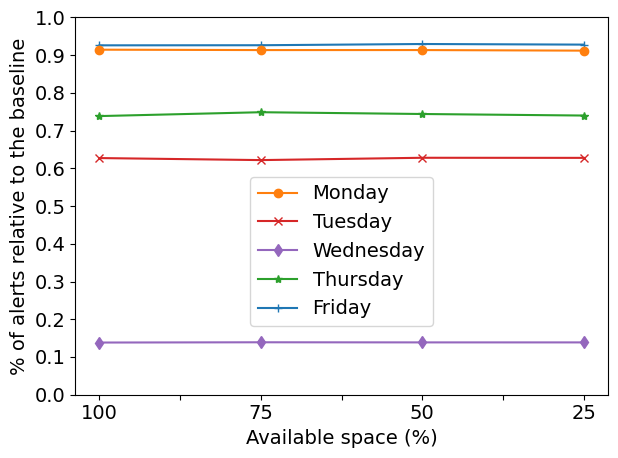

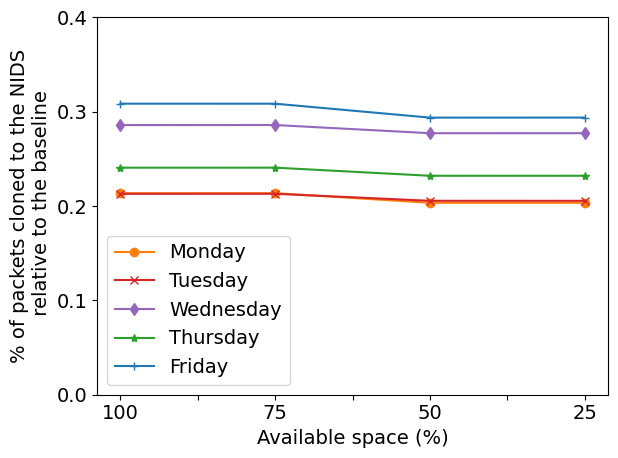

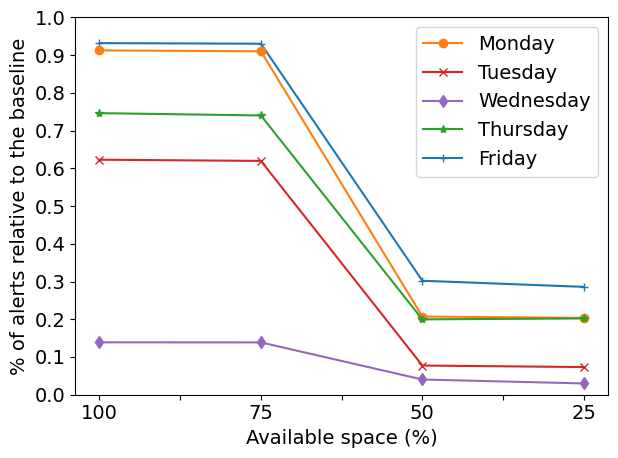

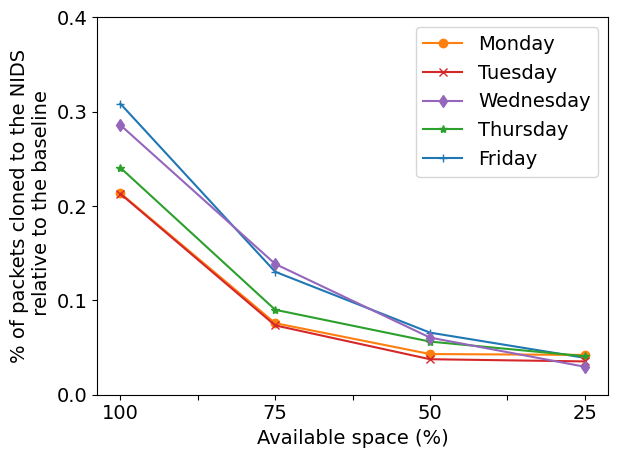

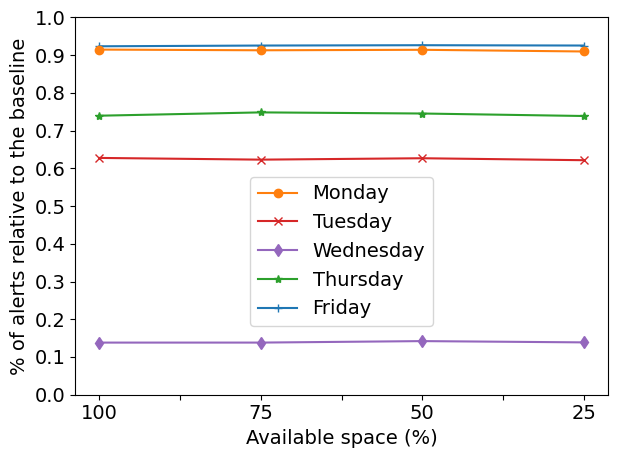

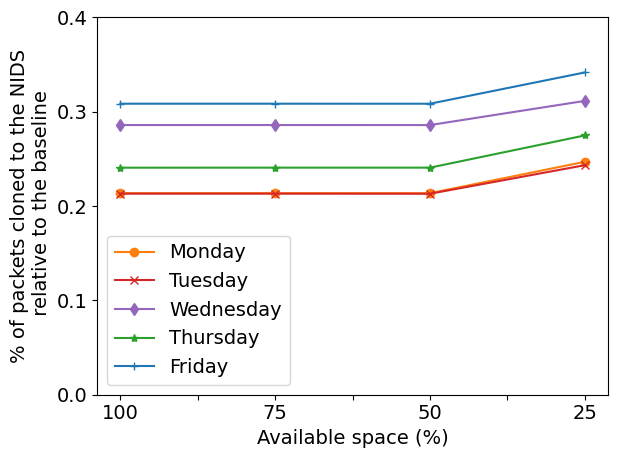

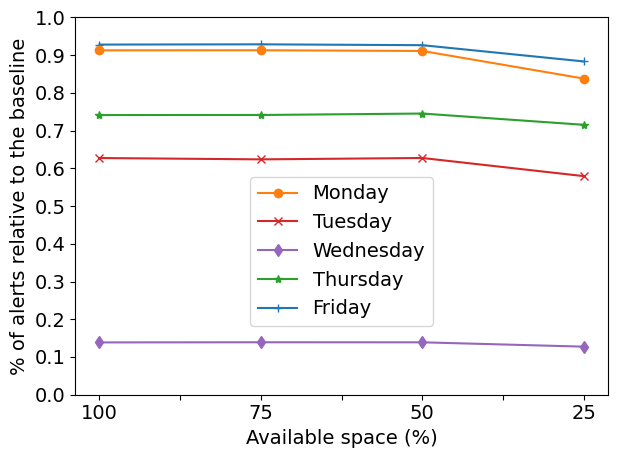

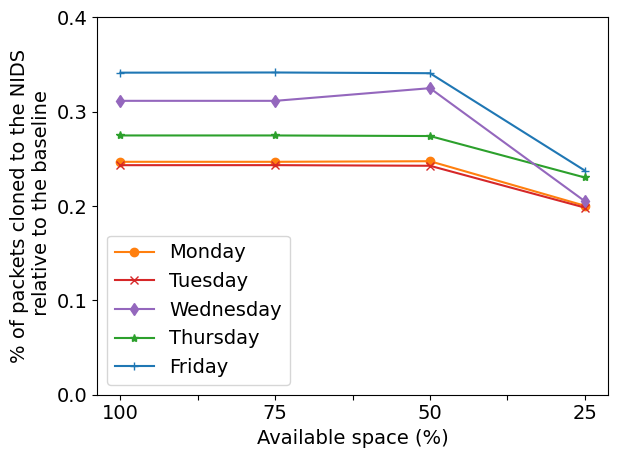

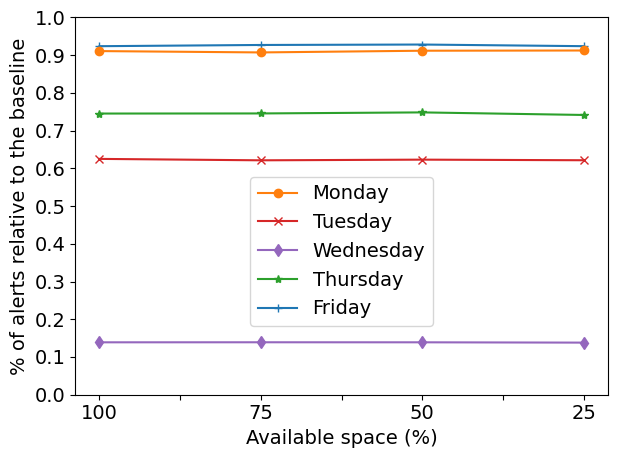

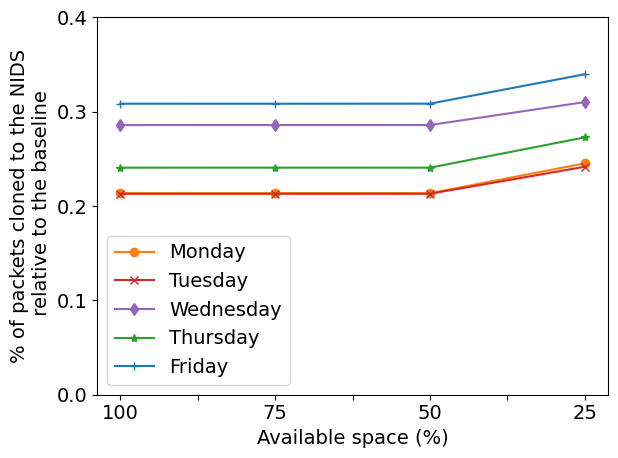

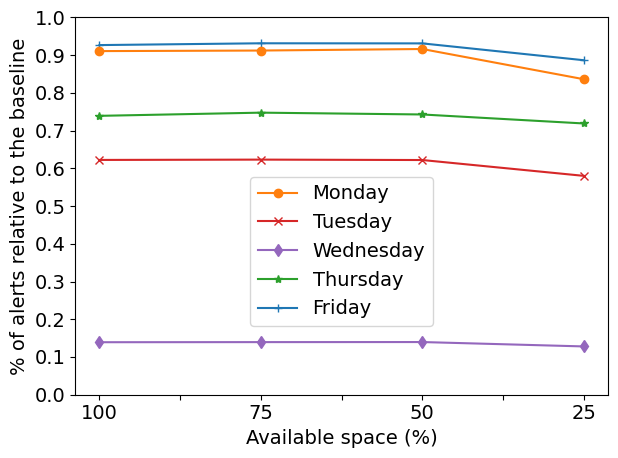

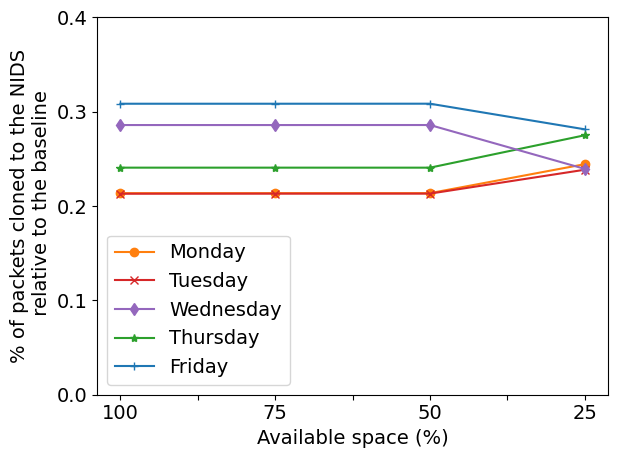

In [12]:
plt.rcParams.update({'font.size': 14})

plot_alerts(alerts_simple_df, "graphs/Alerts_simple_ordered.png")
plot_packets_cloned(packets_simple_df, "graphs/Packets_cloned_simple_ordered.png")

# plot_alerts(alerts_linear_firstfit_df, "graphs/Alerts_linear_firstfit.png")
# plot_packets_cloned(packets_linear_firstfit_df, "graphs/Packets_cloned_linear_firstfit.png")

# plot_alerts(alerts_linear_bestfit_df, "graphs/Alerts_linear_bestfit.png")
# plot_packets_cloned(packets_linear_bestfit_df, "graphs/Packets_cloned_linear_bestfit.png")

# plot_alerts(alerts_tree_firstfit_df, "graphs/Alerts_tree_firstfit.png")
# plot_packets_cloned(packets_tree_firstfit_df, "graphs/Packets_cloned_tree_firstfit.png")

# plot_alerts(alerts_tree_bestfit_df, "graphs/Alerts_tree_bestfit.png")
# plot_packets_cloned(packets_tree_bestfit_df, "graphs/Packets_cloned_tree_bestfit.png")

plot_alerts(alerts_simple_random_df, "graphs/Alerts_simple_random.png", False)
plot_packets_cloned(packets_simple_random_df, "graphs/Packets_cloned_simple_random.png")

plot_alerts(alerts_linear_firstfit_random_df, "graphs/Alerts_linear_firstfit_random.png")
plot_packets_cloned(packets_linear_firstfit_random_df, "graphs/Packets_cloned_linear_firstfit_random.png")

plot_alerts(alerts_linear_bestfit_random_df, "graphs/Alerts_linear_bestfit_random.png")
plot_packets_cloned(packets_linear_bestfit_random_df, "graphs/Packets_cloned_linear_bestfit_random.png")

plot_alerts(alerts_tree_firstfit_random_df, "graphs/Alerts_tree_firstfit_random.png")
plot_packets_cloned(packets_tree_firstfit_random_df, "graphs/Packets_cloned_tree_firstfit_random.png")

plot_alerts(alerts_tree_bestfit_random_df, "graphs/Alerts_tree_bestfit_random.png")
plot_packets_cloned(packets_tree_bestfit_random_df, "graphs/Packets_cloned_tree_bestfit_random.png")

### Plot the memory utilization 

In [17]:
def create_memory_usage_dataframe(df, topology):
    final_df = df[(df["Topology"]==topology) | (final_eval_df["Offloading algorithm"]=="simple") & ~(final_eval_df["Offloading algorithm"].str.contains("random"))]
    final_df = final_df[["Offloading algorithm", "Available space (%)", "Table entries used"]]
    final_df = final_df.drop_duplicates(subset=["Offloading algorithm", "Available space (%)"], keep='last')
    final_df = final_df.reset_index(drop=True) 
    final_df = final_df.pivot_table("Table entries used", ["Available space (%)"], "Offloading algorithm")
    final_df = pd.DataFrame(final_df, columns=['simple','firstfit','bestfit'])

    return final_df

def plot_memory_usage(df, duplicate_memeory, filename):
    _, ax = plt.subplots()
    df.plot(kind='bar', ax=ax, width=0.7) 
    duplicate_memory.plot(kind='bar', ax=ax, rot=0, width=0.7, color=['grey'], edgecolor='black')


    grey_patch = mpatches.Patch(color='grey')
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = handles[0:3]
    order = [1,3,4,2,0]
    handles.append(grey_patch)
    labels = ["Simple", "First-fit", "Best-fit"]
    labels.append("Duplicates")
    ax.legend(handles, labels, bbox_to_anchor=(1.02,1), loc='upper left', borderaxespad=0)
    ax.margins(y=0.1)
    for i in range(0,6):
        ax.bar_label(ax.containers[i], label_type='edge', rotation=30)

    plt.ylabel("Table entries")
    plt.tight_layout()
    plt.savefig(filename)

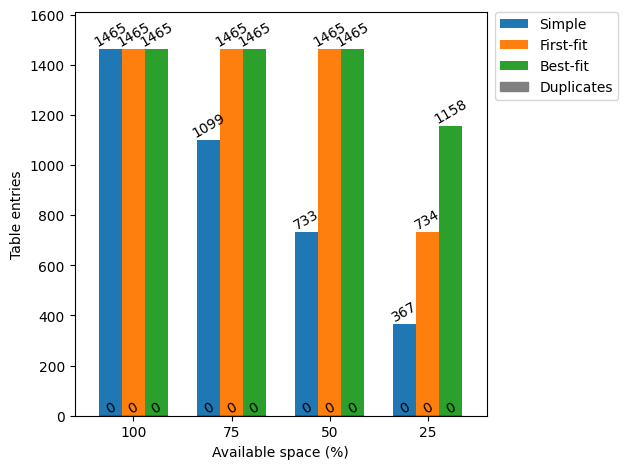

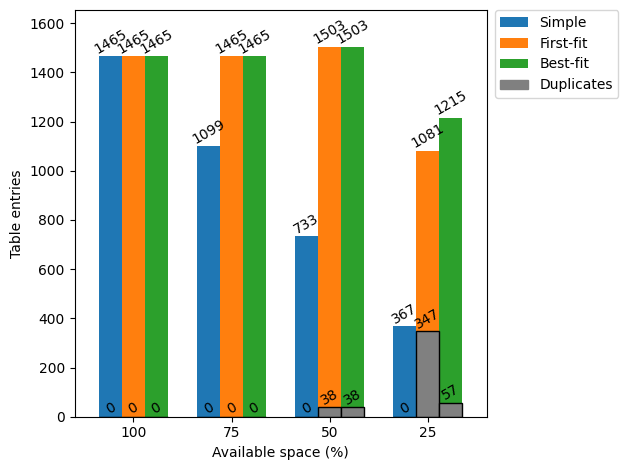

In [18]:
plt.rcParams.update({'font.size': 10})

linear_memory_plot_df = create_memory_usage_dataframe(final_eval_df, "linear")
linear_memory_plot_df = linear_memory_plot_df.iloc[::-1]
duplicate_memory = linear_memory_plot_df.copy()
duplicate_memory.iloc[0:4] = 0
plot_memory_usage(linear_memory_plot_df,duplicate_memory,"graphs/Linear_table_entries_usage.png")

tree_memory_plot_df = create_memory_usage_dataframe(final_eval_df, "tree")
tree_memory_plot_df = tree_memory_plot_df.iloc[::-1]
duplicate_memory = tree_memory_plot_df.copy()
duplicate_memory.iloc[0:4] = 0
duplicate_memory.iloc[2,1:3] = 38
duplicate_memory.at[25, 'firstfit'] = 347
duplicate_memory.at[25, 'bestfit'] = 57

plot_memory_usage(tree_memory_plot_df,duplicate_memory,"graphs/Tree_table_entries_usage.png") 